In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df['Name'].value_counts()

Leader, Dr. Alice (Farnham)        1
Foreman, Mr. Benjamin Laventall    1
Johanson, Mr. Jakob Alfred         1
Lam, Mr. Ali                       1
Shellard, Mr. Frederick William    1
                                  ..
Brewe, Dr. Arthur Jackson          1
Simmons, Mr. John                  1
Bostandyeff, Mr. Guentcho          1
Hanna, Mr. Mansour                 1
Baclini, Miss. Eugenie             1
Name: Name, Length: 891, dtype: int64

In [6]:
null_vals = train_df.isna().sum().sort_values(ascending=False)
null_vals[null_vals > 0 ]

Cabin       687
Age         177
Embarked      2
dtype: int64

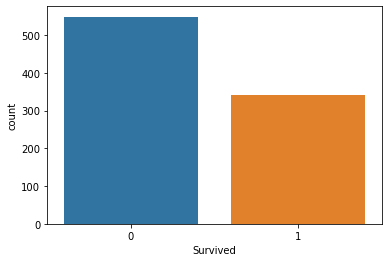

In [7]:
sns.countplot(
   x =  train_df["Survived"].values,
).set_xlabel("Survived");


# Merging train and test sets for Preprocessing

In [8]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df['Survived'].values
test_IDs = test_df['PassengerId'].copy()
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['Survived','PassengerId','Cabin', 'Ticket'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (1309, 8)


In [9]:
null_vals = all_data.isna().sum().sort_values(ascending=False)
null_vals[null_vals > 0 ]

Age         263
Embarked      2
Fare          1
dtype: int64

# Removing Null values

### For colls with small amounts of missing data <5

In [10]:
#all_data['Lifeboat'] = all_data['Lifeboat'].fillna('None')

In [11]:
for col in null_vals[(null_vals <10) &( null_vals > 0)  ].index : 
    all_data[col] = all_data.groupby(["Pclass","Sex"])[col].transform(
        lambda x: x.fillna(x.mode()[0]))

### For categorical data : 

In [12]:
categorical_col = []
for col in all_data.columns:
    if all_data[col].dtype in [object , bool] and len(all_data[col].unique()) <= 50:
        categorical_col.append(col)
categorical_col

['Sex', 'Embarked']

In [13]:
for col in categorical_col: 
    print(col)
    print(f'number of null entries in col : {all_data[col].isnull().sum()}')
    print(all_data[col].value_counts())
    print('*'*100)

Sex
number of null entries in col : 0
male      843
female    466
Name: Sex, dtype: int64
****************************************************************************************************
Embarked
number of null entries in col : 0
S    914
C    272
Q    123
Name: Embarked, dtype: int64
****************************************************************************************************


Our data looks fairly distributed with mostly one category in each holding most entries, so it would be acceptable to change our null values to the mode of each feature

In [14]:
for col in categorical_col:
    print(f"{col} mode : {all_data[col].mode()[0]}")
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

Sex mode : male
Embarked mode : S


### for our numerical features : 

In [15]:
all_data['Age'].isnull().sum()

263

In [16]:
all_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


# Feature Engeneering

In [17]:
# FamilySize
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1

# IsAlone
all_data['IsAlone'] = all_data['FamilySize'] <= 1


In [18]:
all_data['Title'] = all_data['Name'].apply(lambda x : x.split(' ')[1].strip('123,./!?'))
all_data.drop('Name', axis = 1 , inplace = True)
all_data['Title'] = all_data['Title'].apply(lambda x : x if x in ['Mr','Miss','Mrs','Master'] else 'NoTitle')
all_data['Title'].value_counts()

Mr         736
Miss       256
Mrs        191
NoTitle     67
Master      59
Name: Title, dtype: int64

In [19]:
all_data['Title'] = all_data['Title'].map({'NoTitle' : 0 , 'Miss': 1, 'Mrs' : 2,'Mr' :3 ,'Master' : 4})
all_data['Title'].value_counts()

3    736
1    256
2    191
0     67
4     59
Name: Title, dtype: int64

In [20]:
all_data["Age"].value_counts()

24.00    47
22.00    43
21.00    41
30.00    40
18.00    39
         ..
20.50     1
11.50     1
22.50     1
0.33      1
60.50     1
Name: Age, Length: 98, dtype: int64

In [21]:
all_data['Age'] = all_data.groupby(['Pclass', 'Sex','Title']).Age.apply(lambda x: x.fillna(x.median()))


In [22]:
all_data["Age"].value_counts()

26.00    165
18.00     86
30.00     55
24.00     47
42.00     45
        ... 
26.50      1
11.50      1
76.00      1
0.33       1
60.50      1
Name: Age, Length: 98, dtype: int64

## Label encoding our categorical data

In [23]:
categorical_col = []
for col in all_data.columns:
    if all_data[col].dtype in [object, bool] and len(all_data[col].unique()) <= 50:
        categorical_col.append(col)
categorical_col

['Sex', 'Embarked', 'IsAlone']

In [24]:
for col in categorical_col:
    all_data[col] = all_data[col].astype("category").cat.codes
all_data[categorical_col].head()

,Sex,Embarked,IsAlone
0,1,2,0
1,0,0,0
2,0,2,1
3,0,2,0
4,1,2,1


In [25]:
all_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title
0,3,1,22.0,1,0,7.2500,2,2,0,3
1,1,0,38.0,1,0,71.2833,0,2,0,2
2,3,0,26.0,0,0,7.9250,2,1,1,1
3,1,0,35.0,1,0,53.1000,2,2,0,2
4,3,1,35.0,0,0,8.0500,2,1,1,3


In [26]:
"""from scipy.stats import norm, skew #for some statistics

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10) , skewness.shape"""

'from scipy.stats import norm, skew #for some statistics\n\nnumeric_feats = all_data.dtypes[all_data.dtypes != "object"].index\n\n# Check the skew of all numerical features\nskewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)\nprint("\nSkew in numerical features: \n")\nskewness = pd.DataFrame({\'Skew\' :skewed_feats})\nskewness.head(10) , skewness.shape'

In [27]:
"""skewness = skewness[abs(skewness['Skew']) > 4 ]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
    
all_data[skewed_features] = np.log1p(all_data[skewed_features])"""

'skewness = skewness[abs(skewness[\'Skew\']) > 4 ]\nprint("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))\n\nskewed_features = skewness.index\n    \nall_data[skewed_features] = np.log1p(all_data[skewed_features])'

# One Hot Encoding

In [28]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto')

#One-hot-encode the categorical columns.
#Unfortunately outputs an array instead of dataframe.
array_hot_encoded = ohe.fit_transform(all_data[categorical_col]).toarray()

#Convert it to df
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=all_data.index)

#Extract only the columns that didnt need to be encoded
data_other_cols = all_data.drop(columns=categorical_col)

#Concatenate the two dataframes : 
all_data = pd.concat([data_hot_encoded, data_other_cols], axis=1)

In [29]:
all_data.head()

,0,1,2,3,4,5,6,Pclass,Age,SibSp,Parch,Fare,FamilySize,Title
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3,22.0,1,0,7.2500,2,3
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,38.0,1,0,71.2833,2,2
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3,26.0,0,0,7.9250,1,1
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1,35.0,1,0,53.1000,2,2
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3,35.0,0,0,8.0500,1,3


In [30]:
all_data.shape

(1309, 14)

In [31]:
print('in',all_data.columns.map(type))
all_data.columns = all_data.columns.astype(str)
print('out',all_data.columns.map(type))

in Index([<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>,
       <class 'int'>, <class 'int'>, <class 'int'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>],
      dtype='object')
out Index([<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>],
      dtype='object')


# Spliting test and train data

In [32]:
train_data = all_data[:ntrain].copy()
test_data = all_data[ntrain:]

train_data['Survived'] = y_train

train_data.shape , test_data.shape

((891, 15), (418, 14))

In [33]:
train_data['Survived'] = train_data['Survived'].astype("category").cat.codes

In [34]:
train_data.head()

,0,1,2,3,4,5,6,Pclass,Age,SibSp,Parch,Fare,FamilySize,Title,Survived
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3,22.0,1,0,7.2500,2,3,0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,38.0,1,0,71.2833,2,2,1
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3,26.0,0,0,7.9250,1,1,1
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1,35.0,1,0,53.1000,2,2,1
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3,35.0,0,0,8.0500,1,3,0


# Selecting best features

In [35]:
k = 12 #number of variables for heatmap
cols = train_data.corr().abs().nlargest(k, 'Survived')['Survived'].index
"""f,ax = plt.subplots(figsize=(11, 11))
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()"""
cols


Index(['Survived', '0', '1', 'Title', 'Pclass', 'Fare', '5', '6', '2', '4',
       'Parch', 'Age'],
      dtype='object')

In [36]:
print(type(cols))

<class 'pandas.core.indexes.base.Index'>


In [37]:
train_data = train_data[cols]
test_data = test_data[cols.drop('Survived')]
train_data.shape , test_data.shape

((891, 12), (418, 11))

# Clearing outliers

In [38]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(contamination = 0.02)
#identify outliers:
outliers = clf.fit_predict(train_data)
#Remove outliers where 1 represent inliers and -1 represent outliers:
train_data_cleaned = train_data[np.where(outliers == 1, True, False)]
train_data_cleaned.shape

(873, 12)

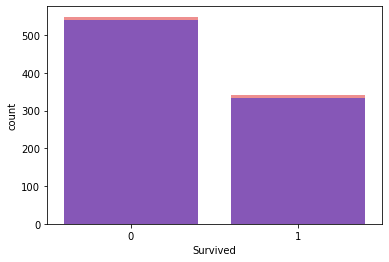

In [39]:
sns.countplot( x =train_data['Survived'], label = "Original", color = 'red' , alpha = 0.5)
sns.countplot(x = train_data_cleaned['Survived'], label = "Modified" , color = 'blue',alpha = 0.5)

In [40]:
X_train = train_data_cleaned.drop('Survived', axis = 1)
y_train = train_data_cleaned.Survived
X_train.shape , y_train.shape

((873, 11), (873,))

0    539
1    334
Name: Survived, dtype: int64
0    539
1    539
Name: Survived, dtype: int64


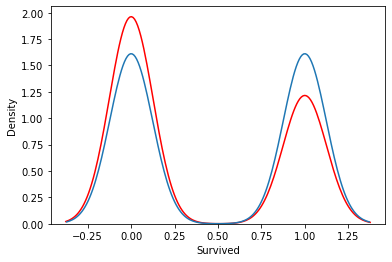

In [41]:
from imblearn.over_sampling import SMOTE
smote = SMOTE( random_state=42)

print(y_train.value_counts())
X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
print(y_resampled.value_counts())

sns.kdeplot(y_train, label = "Original" , color = 'red')
sns.kdeplot(y_resampled, label = "Modified")
X_train = X_resampled
y_train = y_resampled

## Model Selection

In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import GradientBoostingClassifier

In [43]:
from sklearn.pipeline import Pipeline

pipeline_dt=Pipeline([('GaussianNB',GaussianNB())])
pipeline_knn=Pipeline([('KNeighborsClassifier',KNeighborsClassifier())])
pipeline_rf=Pipeline([ ('RandomForestClassifier',RandomForestClassifier())])
pipeline_dt=Pipeline([ ('DecisionTreeClassifier',DecisionTreeClassifier())])
pipeline_xgb=Pipeline([ ('XGBClassifier',XGBClassifier())])
pipeline_lgr=Pipeline([ ('LogisticRegression',LogisticRegression(solver='lbfgs', max_iter=3000))])
pipeline_lgbm=Pipeline([ ('LGBMClassifier',LGBMClassifier(objective='binary'))])
pipeline_catB=Pipeline([ ('CatBoostClassifier',CatBoostClassifier(verbose = 0 ))])
#pipeline_adaB=Pipeline([ ('AdaBoostClassifier',AdaBoostClassifier())])
pipeline_adaB=Pipeline([ ('AdaBoostClassifier',GradientBoostingClassifier())])

pipelines = [pipeline_dt, pipeline_knn, pipeline_rf,pipeline_dt,pipeline_xgb , pipeline_lgr , pipeline_lgbm , pipeline_catB , pipeline_adaB]
pipe_dict = {0: 'GaussianNB', 1: 'KNeighborsClassifier', 2: 'RandomForestClassifier',
             3: 'DecisionTreeClassifier',4: 'XGBClassifier' , 5 : 'LogisticRegression' ,
             6 : 'LGBMClassifier' , 7 : 'CatBoostClassifier' ,8 : 'AdaBoostClassifier'}

In [44]:
#uncomment if gonna use  pipelines[x]
"""for pipe in pipelines:
    pipe.fit(X_train, y_train)"""

'for pipe in pipelines:\n    pipe.fit(X_train, y_train)'

In [45]:
from sklearn.metrics import accuracy_score
original_results = dict()
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train.values,y_train.values.ravel(), cv=3 ,scoring='accuracy').mean()
    #print(model.get_params())
    original_results[pipe_dict[i]] = cv_score

/Users/randyllpandohie/opt/anaconda3/envs/renvironment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:04:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:04:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:04:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

In [46]:
for key , value in sorted(original_results.items(),key=lambda item : item[1]):
    print(key , value) 

KNeighborsClassifier 0.7542246982358402
LogisticRegression 0.8033580934695141
GaussianNB 0.8107990302279996
DecisionTreeClassifier 0.8145078922934076
XGBClassifier 0.8367636438667079
AdaBoostClassifier 0.8376895697926338
LGBMClassifier 0.8395465800061901
RandomForestClassifier 0.8404802434746724
CatBoostClassifier 0.8451021355617455


In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, PowerTransformer
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
test_data_scaled = scaler.transform(test_data)

In [48]:
from sklearn.metrics import accuracy_score
original_results = dict()
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train_scaled,y_train.values.ravel(), cv=3 ,scoring='accuracy').mean()
    #print(model.get_params())
    original_results[pipe_dict[i]] = cv_score

/Users/randyllpandohie/opt/anaconda3/envs/renvironment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:04:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:04:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:04:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

In [49]:
for key , value in sorted(original_results.items(),key=lambda item : item[1]):
    print(key , value) 

LogisticRegression 0.802432167543588
GaussianNB 0.8117275353347777
KNeighborsClassifier 0.8126225110904777
DecisionTreeClassifier 0.815438976581038
RandomForestClassifier 0.8358480346641907
XGBClassifier 0.8367636438667079
AdaBoostClassifier 0.838618074899412
LGBMClassifier 0.8423320953265243
CatBoostClassifier 0.8451021355617455


## Let's apply some Grid search for the top 4 performing models 

In [50]:
test_data.isnull().sum()

0         0
1         0
Title     0
Pclass    0
Fare      0
5         0
6         0
2         0
4         0
Parch     0
Age       0
dtype: int64

In [51]:
"""from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, PowerTransformer

skf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

X = train_data.drop(columns='Survived', axis=1)
y = train_data['Survived']
X_submission = test_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'max_depth': range(0,5), 
              'n_estimators': range(0,10), 
              'max_features': ['sqrt', 'auto'], 
              'random_state': [42], 
              'warm_start': [True]}

grid = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, n_jobs=-1, cv=skf, verbose=1).fit(X_train_scaled, y_train)

print('Test score:', grid.score(X_test_scaled, y_test))
print('Best params:\n{}'.format(grid.best_params_))
"""

"from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold\nfrom sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, PowerTransformer\n\nskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)\n\nX = train_data.drop(columns='Survived', axis=1)\ny = train_data['Survived']\nX_submission = test_data\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)\n\nscaler = StandardScaler().fit(X_train)\nX_train_scaled = scaler.transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n\nparam_grid = {'max_depth': range(0,5), \n              'n_estimators': range(0,10), \n              'max_features': ['sqrt', 'auto'], \n              'random_state': [42], \n              'warm_start': [True]}\n\ngrid = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, n_jobs=-1, cv=skf, verbose=1).fit(X_train_scaled, y_train)\n\nprint('Tes

In [52]:
#Cat Boost Classifier
cat = CatBoostClassifier(eval_metric='Accuracy',
                        verbose = 0)

#USING GRID SEARCH
params_catB = {
    'learning_rate' : [0.01,0.02,0.03,],
          'depth': [6,7,],
    'iterations' : [450,1000,]
         }

grid_search_cat = GridSearchCV(estimator=cat,verbose = 1, param_grid=params_catB, cv = 3,scoring='accuracy',n_jobs=-1).fit(X_train.values, y_train.values.ravel())
cat_best = grid_search_cat.best_estimator_
print('CatBoost Best Score',grid_search_cat.best_score_)
print('CatBoost Best Parmas',grid_search_cat.best_params_)
print('CatBoost Accuracy',cross_val_score(cat_best,X_train.values, y_train.values.ravel(), cv=3).mean())

"""#Random Forest Regressor
rfc = RandomForestClassifier()

#USING GRID SEARCH
params_rf = {'n_estimators': [100,200,300,],
             'max_depth': [10]}

grid_search_rfc = GridSearchCV(estimator=rfc,verbose = 1, param_grid=params_rf, cv = 3,scoring='accuracy',n_jobs=-1).fit(X_train.values, y_train.values.ravel())
rfc_best = grid_search_rfc.best_estimator_
print('Random Forest Best Score',grid_search_rfc.best_score_)
print('Random Forest Best Parmas',grid_search_rfc.best_params_)
print('Random Forest Accuracy',cross_val_score(rfc_best,X_train.values, y_train.values.ravel(), cv=5).mean())"""




Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    8.3s finished


CatBoost Best Score 0.8488187351697102
CatBoost Best Parmas {'depth': 6, 'iterations': 450, 'learning_rate': 0.03}
CatBoost Accuracy 0.8488187351697102


"#Random Forest Regressor\nrfc = RandomForestClassifier()\n\n#USING GRID SEARCH\nparams_rf = {'n_estimators': [100,200,300,],\n             'max_depth': [10]}\n\ngrid_search_rfc = GridSearchCV(estimator=rfc,verbose = 1, param_grid=params_rf, cv = 3,scoring='accuracy',n_jobs=-1).fit(X_train.values, y_train.values.ravel())\nrfc_best = grid_search_rfc.best_estimator_\nprint('Random Forest Best Score',grid_search_rfc.best_score_)\nprint('Random Forest Best Parmas',grid_search_rfc.best_params_)\nprint('Random Forest Accuracy',cross_val_score(rfc_best,X_train.values, y_train.values.ravel(), cv=5).mean())"

In [ ]:
#XGBR Forest Classifier
xgbr = XGBClassifier(objective='binary:logistic')
                     
#USING GRID SEARCH
params_xgb = {'booster' : ['gbtree',],
    'gamma': [0],
              'learning_rate': [0.01,0.02,0.03,0.1],
              'max_depth': [3,4,5,6,7],
              'n_estimators': [500,1000],
              'reg_alpha': [0,],
              'reg_lambda': [1,],}

grid_search_xgb = GridSearchCV(estimator=xgbr,verbose = 1, param_grid=params_xgb, cv = 3,scoring='accuracy',n_jobs=-1).fit(X_train.values, y_train.values.ravel())
xgbr_best = grid_search_xgb.best_estimator_
print('xgbr_best Best Score',grid_search_xgb.best_score_)
print('xgbr_best Best Parmas',grid_search_xgb.best_params_)
print('xgbr_best Accuracy',cross_val_score(xgbr_best,X_train.values, y_train.values.ravel(), cv=3).mean())


#LGBM Forest Classifier
lgbm = LGBMClassifier(objective='binary')

#USING GRID SEARCH
params_lgbm = {
    'learning_rate': [0.01,0.03,0.1,],
    'num_leaves': [31,41], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'max_bin':[510], # large max_bin helps improve accuracy but might slow down training progress
    'colsample_bytree' : [0.64,0.7],
    'subsample' : [0.7,],
    'reg_alpha' : [0,],
    'reg_lambda' : [0,1],
    }

grid_search_lgbm = GridSearchCV(estimator=lgbm,verbose =1, param_grid=params_lgbm, cv = 3,scoring='accuracy',n_jobs=-1).fit(X_train.values, y_train.values.ravel())
lgbm_best = grid_search_lgbm.best_estimator_
print('lgbm_best Best Score',grid_search_lgbm.best_score_)
print('lgbm_best Best Parmas',grid_search_lgbm.best_params_)
print('lgbm_best Accuracy',cross_val_score(lgbm_best,X_train.values, y_train.values.ravel(), cv=3).mean())

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.0min finished
/Users/randyllpandohie/opt/anaconda3/envs/renvironment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:07:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgbr_best Best Score 0.8534715774270092
xgbr_best Best Parmas {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1}
[07:07:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/randyllpandohie/opt/anaconda3/envs/renvironment/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:07:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:07:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgbr_best Accuracy 0.8534715774270092
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s


In [ ]:
test_data.shape

In [ ]:
predictions = xgbr_best.predict(test_data.values)

In [ ]:
sub = pd.DataFrame()
sub['PassengerId'] = test_IDs
sub['Survived'] = predictions
sub['Survived'] = sub['Survived']
sub.to_csv('submission.csv',index=False)

In [ ]:
sub.head()